In [101]:
#loading libraries
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

In [3]:
#loading dataset
train = pd.read_csv("train.csv")

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

### Data quality check
*By Blanka Jarmoszko*

The code below visualizes the distribution of all the variables in the dataset, and their association with the response.

In [4]:
#...Distribution of continuous variables...#

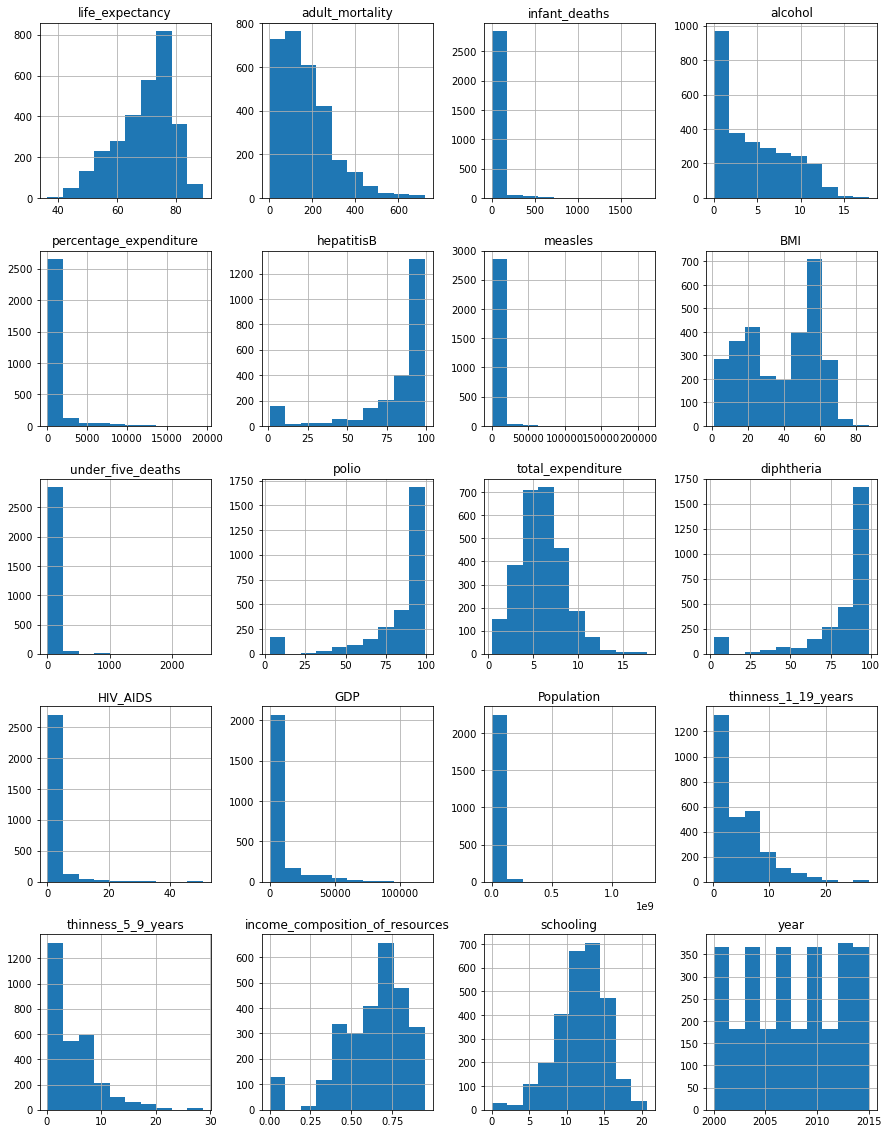

In [5]:
%matplotlib inline
train.hist (column= ['life_expectancy','adult_mortality', 'infant_deaths','alcohol', 'percentage_expenditure', 'hepatitisB',
       'measles', 'BMI', 'under_five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'HIV_AIDS', 'GDP', 'Population', 'thinness_1_19_years',
       'thinness_5_9_years', 'income_composition_of_resources', 'schooling','year'],figsize= (15,20))
#hides array names that are otherwise printed
_ = plt.plot()

In [6]:
#...Distribution of categorical variables...#

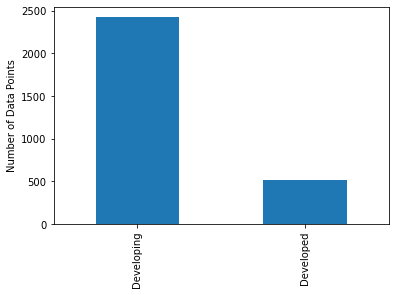

In [7]:
ax = train['status'].value_counts().plot.bar(ylabel = 'Number of Data Points')

In [8]:
#...Association of the response with the predictors...#

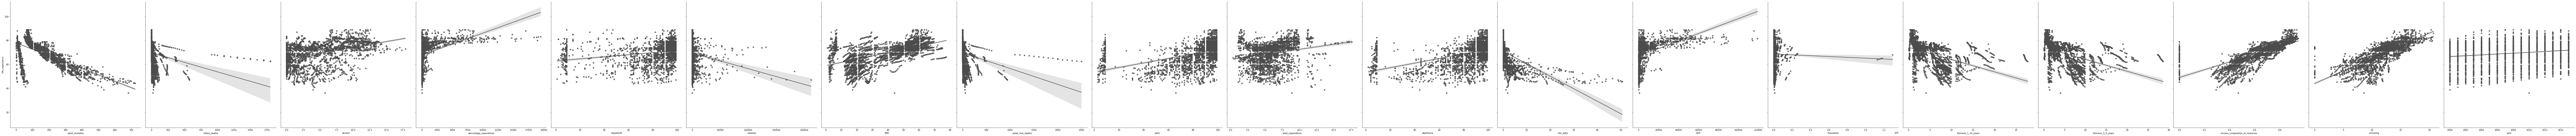

In [9]:
#plotting a scatterplot of life expectancy vs all the other numerical variables to investigate distribution
g = sns.PairGrid(train, y_vars=["life_expectancy"], x_vars=['adult_mortality', 'infant_deaths','alcohol', 'percentage_expenditure', 'hepatitisB',
       'measles', 'BMI', 'under_five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'HIV_AIDS', 'GDP', 'Population', 'thinness_1_19_years',
       'thinness_5_9_years', 'income_composition_of_resources', 'schooling','year'], height=9)
g.map(sns.regplot, color=".3")


/var/folders/xb/mpc8k2d54673jvhxz1y15twc0000gn/T/ipykernel_2656/3738112974.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr())


<AxesSubplot:>

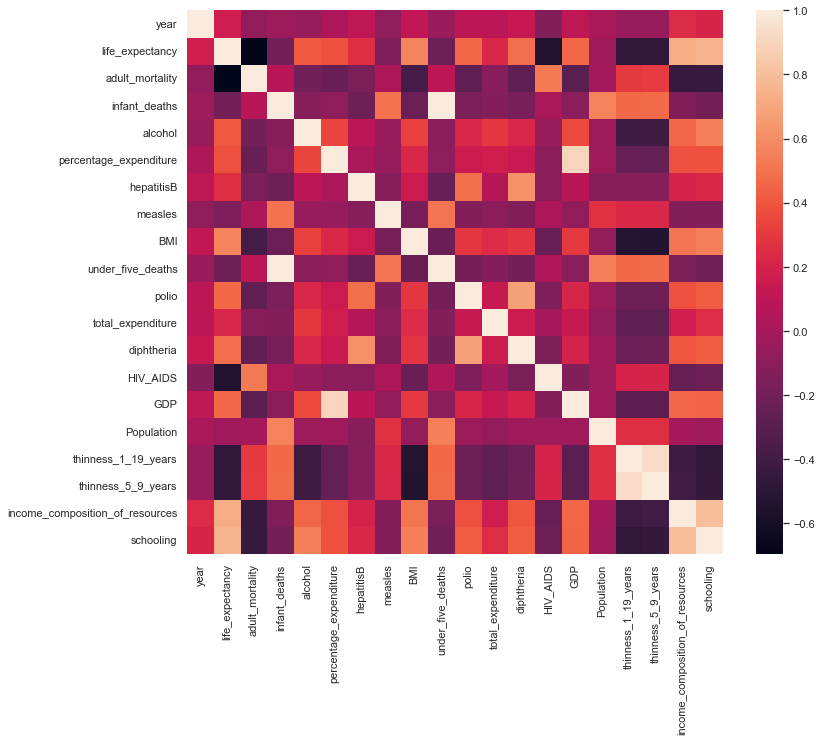

In [10]:
sns.set(rc={'figure.figsize':(12,10)})
sns.heatmap(train.corr())

In [11]:
#missing values
train.isnull().sum().sort_values()

country                              0
year                                 0
status                               0
infant_deaths                        0
percentage_expenditure               0
measles                              0
HIV_AIDS                             0
under_five_deaths                    0
life_expectancy                     10
adult_mortality                     10
polio                               19
diphtheria                          19
thinness_5_9_years                  34
thinness_1_19_years                 34
BMI                                 34
schooling                          163
income_composition_of_resources    167
alcohol                            194
total_expenditure                  226
GDP                                448
hepatitisB                         553
Population                         652
dtype: int64

### Data cleaning
*By Blanka Jarmoszko*

From the data quality check we realized that:

1. The column `BMI` has many unreasonably high and low values. The BMI scale ranges between 18-35. However, when looking at the value distributuions over half of the data is outside of those values. To investigate this issue, I found the original WHO data with BMI values for each country over the years of 2000-2015 that our dataset is supposed to utilize. With the initial values BMI looks highly correlated with life-expectancy, in order to fix this issue we will replace the BMI values with the correct values from this data source:
https://www.who.int/data/gho/data/indicators/indicator-details/GHO/mean-bmi-(kg-m-)-(age-standardized-estimate)

2. The column `GDP` has many missing values. Due to that it will be hard to impute the values, however based on the present values  `GDP` has a very strong correlation with `percentage_expenditure` thus we can just use keep `percentage_expenditure` and drop GDP. This will also prevent future issues with collinearity that would most likely be present if both `GDP` and `percentage_expenditure` were selected for the model.

3. There are few columns with missing variables, based on the heatplot they are not strongly correlated with life expectancy nor do they appear to have a non-linear correlation. Thus we will not be imputing those variables for now.

The code below implements the above cleaning.

In [12]:
#...Code with comments...#

In [13]:
train = train.drop(['BMI','GDP'],axis=1)

In [14]:
#imputing bmi values
bmi = pd.read_csv('bmi.csv')

In [15]:
bmi = bmi.drop(['IndicatorCode', 'Indicator', 'ValueType', 'ParentLocationCode',
       'ParentLocation', 'Location type', 'SpatialDimValueCode',
       'Period type', 'IsLatestYear', 'Dim1 type',
       'Dim1ValueCode', 'Dim2 type', 'Dim2', 'Dim2ValueCode', 'Dim3 type',
       'Dim3', 'Dim3ValueCode', 'DataSourceDimValueCode', 'DataSource',
       'FactValueNumericPrefix','FactValueUoM',
       'FactValueNumericLowPrefix',
       'FactValueNumericHighPrefix',
       'FactValueTranslationID', 'FactComments', 'Language', 'DateModified','FactValueNumericLow','FactValueNumericHigh','Value'], axis=1)
bmi.drop(bmi[bmi['Period'] > 2015].index, inplace = True)
bmi.drop(bmi[bmi['Period'] < 2000].index, inplace = True)
bmi.drop(bmi[bmi['Dim1'] != 'Both sexes'].index, inplace = True)
bmi['country']=bmi['Location']
bmi['year'] = bmi['Period']
#bmi.drop(bmi[bmi['Location','Period']].index, inplace = True)
bmi = bmi.drop(['Location','Period'], axis=1)

merged = pd.merge(train,bmi,how='left')
merged['BMI']=merged['FactValueNumeric']
merged = merged.drop(['FactValueNumeric','Dim1'],axis=1)
train = merged.copy()

In [16]:
merged = pd.merge(train,bmi,how='left')

array([[<AxesSubplot:title={'center':'BMI'}>]], dtype=object)

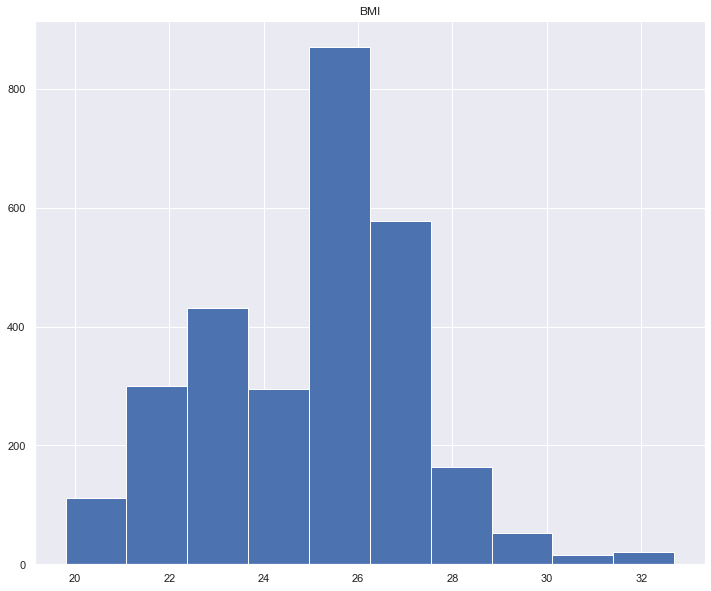

In [17]:
train.hist(column= ['BMI'])

In [18]:
train.isnull().sum().sort_values()

country                              0
HIV_AIDS                             0
measles                              0
percentage_expenditure               0
infant_deaths                        0
under_five_deaths                    0
status                               0
year                                 0
life_expectancy                     10
adult_mortality                     10
polio                               19
diphtheria                          19
thinness_1_19_years                 34
thinness_5_9_years                  34
BMI                                 98
schooling                          163
income_composition_of_resources    167
alcohol                            194
total_expenditure                  226
hepatitisB                         553
Population                         652
dtype: int64

In [19]:
train.head()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitisB,measles,...,polio,total_expenditure,diphtheria,HIV_AIDS,Population,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling,BMI
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,33736494.0,17.2,17.3,0.479,10.1,23.3
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,327582.0,17.5,17.5,0.476,10.0,23.2
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,31731688.0,17.7,17.7,0.470,9.9,23.0
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,3696958.0,17.9,18.0,0.463,9.8,22.9
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,2978599.0,18.2,18.2,0.454,9.5,22.8


### Data preparation
*By Blanka and Jack*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. We added a one year and five year lagging life expectancy to help the model have better informed decisions. This will be useful for forecasts into the future. 

2. We computed a best subset selection due to already disregarding some variables, which lowered the compute time of the best subset selection to two minutes.  

3. The best subset selection allowed us to disregard two variables as they had a high VIF. WE were still left with many variables, but they all are statistically significant. 

In [20]:
######-----------VIF and Best Subset Selection------------#########

In [21]:
train['developing'] = train.status.apply(lambda x: 1 if x=='Developing'
                       else 0)

#### Split into train and test data set

In [22]:
test = train.copy()[train['year'] > 2010]

In [64]:
test['life_expectancy_lag_one_year'] = test['life_expectancy'].shift(-1)
test['life_expectancy_lag_5_year'] = test['life_expectancy'].shift(-5)

In [23]:
train = train.copy()[train['year'] <= 2010]

In [24]:
train['life_expectancy_lag_one_year'] = train['life_expectancy'].shift(-1)
train['life_expectancy_lag_5_year'] = train['life_expectancy'].shift(-5)

In [25]:
abs(train.corrwith(train.life_expectancy)).sort_values()

/var/folders/xb/mpc8k2d54673jvhxz1y15twc0000gn/T/ipykernel_2656/3824249988.py:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  abs(train.corrwith(train.life_expectancy)).sort_values()


Population                         0.017917
year                               0.111779
measles                            0.157584
infant_deaths                      0.185296
total_expenditure                  0.206703
under_five_deaths                  0.211876
hepatitisB                         0.235122
alcohol                            0.401758
percentage_expenditure             0.403295
polio                              0.472563
thinness_5_9_years                 0.472759
developing                         0.476635
thinness_1_19_years                0.481498
diphtheria                         0.483308
life_expectancy_lag_5_year         0.545096
HIV_AIDS                           0.576526
BMI                                0.617339
income_composition_of_resources    0.674957
adult_mortality                    0.677141
schooling                          0.727770
life_expectancy_lag_one_year       0.897222
life_expectancy                    1.000000
dtype: float64

In [26]:
#Creating a set of predictors from which we need to find the best subset of predictors
X = train[['life_expectancy_lag_one_year', 'life_expectancy_lag_5_year','adult_mortality',
       'alcohol', 'percentage_expenditure','polio',
       'diphtheria', 'HIV_AIDS',  'thinness_1_19_years',
       'thinness_5_9_years', 'income_composition_of_resources', 'schooling',
       'BMI', 'developing']]

In [27]:
train_vif = train.dropna()

In [28]:
X = train_vif[['life_expectancy_lag_one_year', 'life_expectancy_lag_5_year','adult_mortality',
       'alcohol', 'percentage_expenditure','polio',
       'diphtheria', 'HIV_AIDS',  'thinness_1_19_years',
       'thinness_5_9_years', 'income_composition_of_resources', 'schooling',
       'BMI', 'developing']]

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)

                            feature         VIF
0                             const  444.499095
1      life_expectancy_lag_one_year    5.291338
2        life_expectancy_lag_5_year    2.100981
3                   adult_mortality    2.209351
4                           alcohol    2.700973
5            percentage_expenditure    1.438257
6                             polio    1.553126
7                        diphtheria    1.588171
8                          HIV_AIDS    2.207023
9               thinness_1_19_years    7.563561
10               thinness_5_9_years    7.193568
11  income_composition_of_resources    2.622749
12                        schooling    4.206004
13                              BMI    2.406449
14                       developing    1.875122


In [30]:
X = train_vif[['life_expectancy_lag_one_year', 'life_expectancy_lag_5_year','adult_mortality',
       'alcohol', 'percentage_expenditure','polio',
       'diphtheria', 'HIV_AIDS',  'thinness_1_19_years',
       'thinness_5_9_years', 'income_composition_of_resources', 'schooling',
       'BMI', 'developing']]

In [31]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.ols('life_expectancy~' + '+'.join(predictor_subset),data = train).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}

In [32]:
#Function to select the best model amongst all models with 'k' predictors
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [33]:
#Function to select the best model amongst the best models for 'k' predictors, where k = 1,2,3,..
models_best = pd.DataFrame(columns=["Rsquared", "model"])

tic = time.time()
for i in range(1,1+X.shape[1]):
    models_best.loc[i] = getBest_model(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 14 models on 1 predictors in 0.04554605484008789 seconds.
Processed 91 models on 2 predictors in 0.3425023555755615 seconds.
Processed 364 models on 3 predictors in 1.7862510681152344 seconds.
Processed 1001 models on 4 predictors in 7.229840993881226 seconds.
Processed 2002 models on 5 predictors in 13.67654800415039 seconds.
Processed 3003 models on 6 predictors in 23.8089017868042 seconds.
Processed 3432 models on 7 predictors in 30.842973947525024 seconds.
Processed 3003 models on 8 predictors in 27.155839204788208 seconds.
Processed 2002 models on 9 predictors in 18.898458003997803 seconds.
Processed 1001 models on 10 predictors in 10.250725984573364 seconds.
Processed 364 models on 11 predictors in 3.7299351692199707 seconds.
Processed 91 models on 12 predictors in 0.9874470233917236 seconds.
Processed 14 models on 13 predictors in 0.16268539428710938 seconds.
Processed 1 models on 14 predictors in 0.013960838317871094 seconds.
Total elapsed time: 139.16096997261047 sec

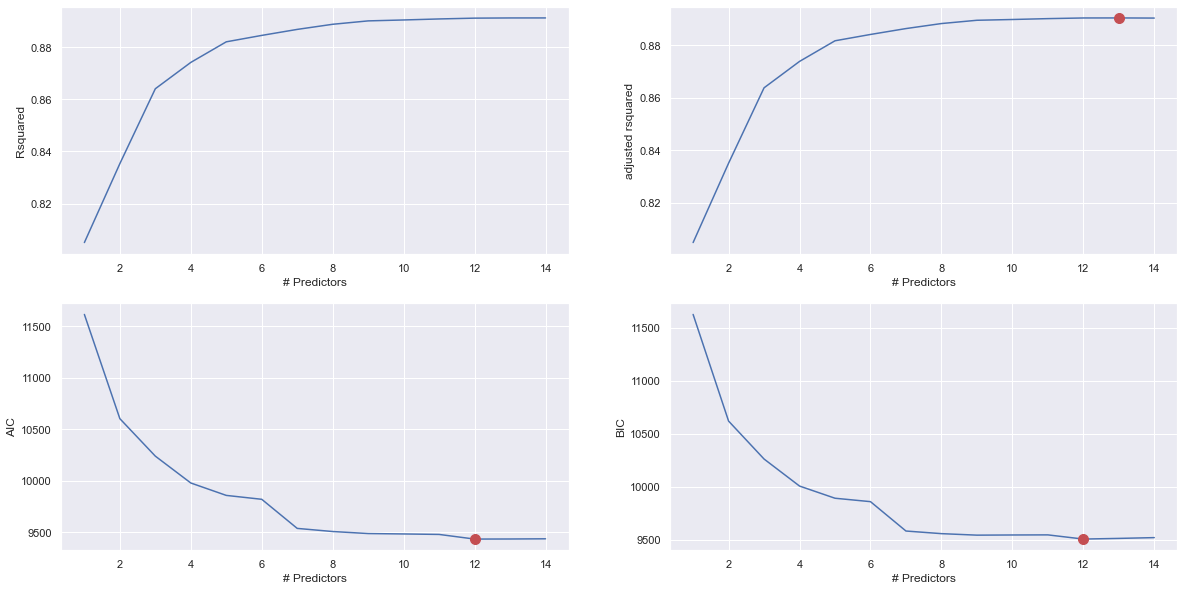

In [34]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

In [35]:
best_subset_model = models_best.loc[12,'model']
model = models_best.loc[12,'model']
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     1244.
Date:                Wed, 15 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:24:17   Log-Likelihood:                -4705.2
No. Observations:                1835   AIC:                             9436.
Df Residuals:                    1822   BIC:                             9508.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          21.5282      1.203     17.896      0.000      19.169      23.888
life_expectancy_lag_one_year        0.4820      0.015     31.342      0.000       0.452       0.512
life_expectancy_lag_5_year         -0.0441      0.010     -4.359      0.000      -0.064      -0.024
adult_mortality                    -0.0075      0.001     -9.189      0.000      -0.009      -0.006
alcohol                            -0.0610      0.025     -2.406      0.016      -0.111      -0.011
percentage_expenditure              0.0002   4.66e-05      4.629      0.000       0.000       0.000
polio                               0.0201      0.004      4.548      0.000       0.011       0.029
diphtheria                          0.0215      0.004      5.171      0.000       0.013       0.030
HIV_AIDS                           -0.3424      0.020    -16.744      0.000      -0.382      -0.302
income_composition_of_resources     3.1631      0.539      5.866      0.000       2.106       4.221
schooling                           0.5228      0.044     12.019      0.000       0.438       0.608
BMI                                 0.3391      0.046      7.354      0.000       0.249       0.430
developing                         -0.9591      0.280     -3.425      0.001      -1.508      -0.410
==============================================================================
Omnibus:                      501.734   Durbin-Watson:                   1.555
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6270.042
Skew:                          -0.919   Prob(JB):                         0.00
Kurtosis:                      11.867   Cond. No.                     3.43e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Drop both thinness measures as they are not statistically significant and have a high VIF

In [36]:
X = train_vif[['life_expectancy_lag_one_year', 'life_expectancy_lag_5_year','adult_mortality',
       'alcohol', 'percentage_expenditure','polio',
       'diphtheria', 'HIV_AIDS', 'income_composition_of_resources', 'schooling',
       'BMI', 'developing']]

In [37]:
######---------------Creating new predictors----------------#########

#Creating number of bedrooms per unit floor area

#Creating ratio of bathrooms to bedrooms

#Creating ratio of carpet area to floor area

In [38]:
######-----------Shuffling the dataset for K-fold------------#########

In [39]:
######-----Standardizing the dataset for Lasso / Ridge-------#########

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

*By Jack*

### KDE to visualize aggregate data. It was had to discern much information from this other than that the lower bound of life expectancy appeared to dramatically increase. Further investigation was needed.

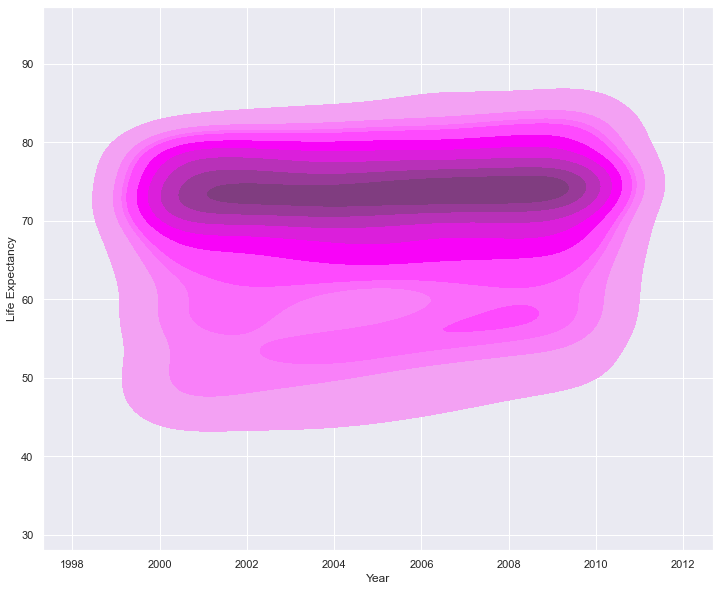

In [40]:
sns.kdeplot(train['year'].values, y=train['life_expectancy'].values,color='purple',shade=True )
plt.xlabel('Year')
plt.ylabel('Life Expectancy')
plt.show()

#### I wanted a more granular picture of what was going on. This data was overwhelming, but it helped to show that life expectancy could fluctuate dramatically. This is why the five year lag was added. 

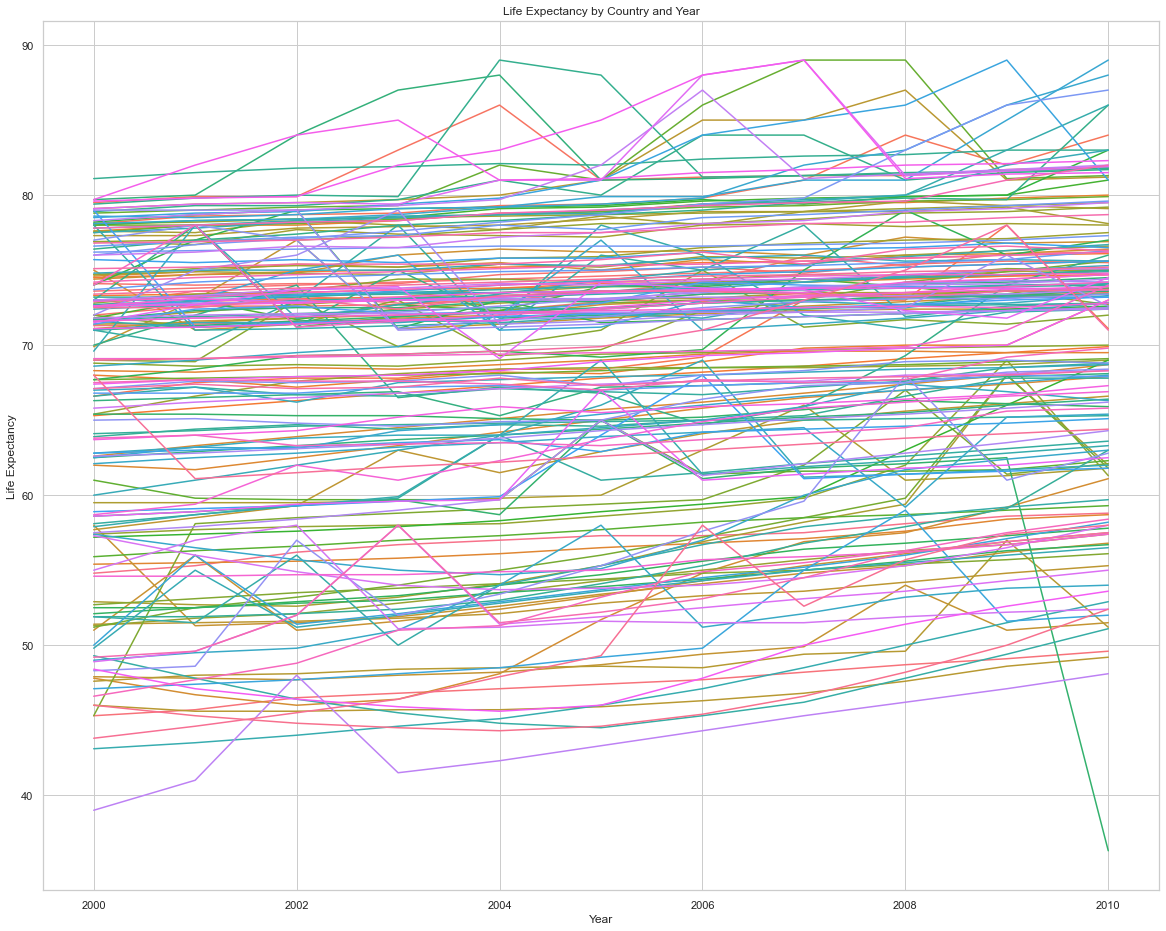

In [41]:
sns.set_style("whitegrid") # Optional: set plot style
plt.figure(figsize=(20, 16))
sns.lineplot(x="year", y="life_expectancy", hue="country", legend=False, data=train)

# Add axis labels and title
plt.xlabel("Year")
plt.ylabel("Life Expectancy")
plt.title("Life Expectancy by Country and Year")

# Show plot
plt.show()

#### Due to an earthquake in 2010, Haiti;s life expectancy fell by nearly thirty years in one year. Haiti's life expectancy rebounded the next year, but it is in the test dataset. This is another reason a five year lag was added. 

In [42]:
outlier = train[train.year == 2010]
outlier = outlier[outlier.life_expectancy < 40]
outlier

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitisB,measles,...,HIV_AIDS,Population,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling,BMI,developing,life_expectancy_lag_one_year,life_expectancy_lag_5_year
1127,Haiti,2010,Developing,36.3,682.0,23,5.76,36.292918,NaN,0,...,1.9,9999617.0,4.0,4.0,0.47,8.6,24.6,1,62.5,65.0


Text(0.5, 1.0, 'Life Expectancy Haiti')

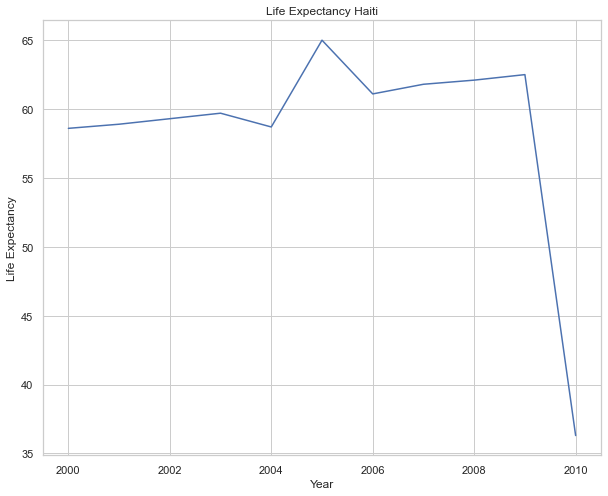

In [43]:
haiti = train[train.country == 'Haiti']
plt.figure(figsize=(10, 8))
sns.lineplot(x="year", y="life_expectancy", hue="country", legend=False, data=haiti)

# Add axis labels and title
plt.xlabel("Year")
plt.ylabel("Life Expectancy")
plt.title("Life Expectancy Haiti")

## Developing the model

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

*By Jack and Blanka*

#### Ridge Regression. The purpose of the Ridge Regression, initially was to make the model more accurate, but Ridge didn't exactly provide that. It had near identical results to the original model. Ridge is extremely useful in gaining the inference from the variables as the variables must be standardized. 

In [58]:
y = train.dropna().life_expectancy

In [59]:
scaler = StandardScaler()

#The scaler object will contain the mean and variance of each column (predictor) of X. 
#These values will be useful to scale test data based on the same mean and variance as obtained on train data
scaler.fit(X)

#Using the scaler object (or the values of mean and variance stored in it) to standardize X (or train data)
Xstd = scaler.transform(X)

In [60]:
alphas = 10**np.linspace(2,0.5,200)*0.5

In [61]:
coefs = []
for a in alphas:        
    ridge = Ridge(alpha = a)
    ridge.fit(Xstd, y)
    coefs.append(ridge.coef_)

In [62]:
ridgecv = RidgeCV(alphas = alphas,store_cv_values=True)
ridgecv.fit(Xstd, y)

#Optimal value of the tuning parameter - lambda
ridgecv.alpha_

/Users/jackokeefe/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)


5.5167534106113125

In [65]:
Xtest = test[['life_expectancy_lag_one_year', 'life_expectancy_lag_5_year','adult_mortality',
       'alcohol', 'percentage_expenditure','polio',
       'diphtheria', 'HIV_AIDS', 'income_composition_of_resources', 'schooling',
       'BMI', 'developing']].dropna()

Xtest_std = scaler.transform(Xtest)

## This is the code that can be used for inference

In [66]:
ridge = Ridge(alpha = ridgecv.alpha_)
ridge.fit(Xstd, y)
pred=ridge.predict(Xtest_std)

In [74]:
df = pd.DataFrame(ridge.coef_, columns = ['coef'])
df['variable'] = ['life_expectancy_lag_one_year', 'life_expectancy_lag_5_year','adult_mortality',
       'alcohol', 'percentage_expenditure','polio',
       'diphtheria', 'HIV_AIDS', 'income_composition_of_resources', 'schooling',
       'BMI', 'developing']

In [75]:
df

,coef,variable
0,5.418297,life_expectancy_lag_one_year
1,-0.102123,life_expectancy_lag_5_year
2,-0.814562,adult_mortality
3,-0.225633,alcohol
4,0.432450,percentage_expenditure
5,0.136257,polio
6,0.211311,diphtheria
7,-1.130423,HIV_AIDS
8,0.469845,income_composition_of_resources
9,1.077867,schooling


## The model through best subset is still the best model. Ridge has limitations as it cannot handle null values. It also aims to reduce the RMSE of the overall model. The result is that for earlier years, the RMSE is extremely high, but for later years, the RMSE is extremely accurate, so the average RMSE is around the same as the OLS model. 

In [85]:
best_subset_model = models_best.loc[12,'model']
model = models_best.loc[12,'model']
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     1244.
Date:                Wed, 15 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:49:00   Log-Likelihood:                -4705.2
No. Observations:                1835   AIC:                             9436.
Df Residuals:                    1822   BIC:                             9508.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          21.5282      1.203     17.896      0.000      19.169      23.888
life_expectancy_lag_one_year        0.4820      0.015     31.342      0.000       0.452       0.512
life_expectancy_lag_5_year         -0.0441      0.010     -4.359      0.000      -0.064      -0.024
adult_mortality                    -0.0075      0.001     -9.189      0.000      -0.009      -0.006
alcohol                            -0.0610      0.025     -2.406      0.016      -0.111      -0.011
percentage_expenditure              0.0002   4.66e-05      4.629      0.000       0.000       0.000
polio                               0.0201      0.004      4.548      0.000       0.011       0.029
diphtheria                          0.0215      0.004      5.171      0.000       0.013       0.030
HIV_AIDS                           -0.3424      0.020    -16.744      0.000      -0.382      -0.302
income_composition_of_resources     3.1631      0.539      5.866      0.000       2.106       4.221
schooling                           0.5228      0.044     12.019      0.000       0.438       0.608
BMI                                 0.3391      0.046      7.354      0.000       0.249       0.430
developing                         -0.9591      0.280     -3.425      0.001      -1.508      -0.410
==============================================================================
Omnibus:                      501.734   Durbin-Watson:                   1.555
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6270.042
Skew:                          -0.919   Prob(JB):                         0.00
Kurtosis:                      11.867   Cond. No.                     3.43e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model was further slimmed due to missing values in some columns, multicolinearity, and the average best subset selection.

In [103]:

model = sm.ols('life_expectancy~adult_mortality+schooling+percentage_expenditure+BMI+diphtheria+HIV_AIDS+income_composition_of_resources+life_expectancy_lag_one_year+life_expectancy_lag_5_year',data = train).fit()

In [104]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     1626.
Date:                Wed, 15 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:59:40   Log-Likelihood:                -4722.7
No. Observations:                1835   AIC:                             9465.
Df Residuals:                    1825   BIC:                             9520.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          20.8195      1.189     17.507      0.000      18.487      23.152
adult_mortality                    -0.0076      0.001     -9.310      0.000      -0.009      -0.006
schooling                           0.5312      0.041     13.028      0.000       0.451       0.611
percentage_expenditure              0.0003   4.42e-05      5.786      0.000       0.000       0.000
BMI                                 0.3221      0.045      7.098      0.000       0.233       0.411
diphtheria                          0.0320      0.003      9.257      0.000       0.025       0.039
HIV_AIDS                           -0.3440      0.021    -16.681      0.000      -0.384      -0.304
income_composition_of_resources     3.3355      0.542      6.160      0.000       2.273       4.397
life_expectancy_lag_one_year        0.4915      0.015     31.861      0.000       0.461       0.522
life_expectancy_lag_5_year         -0.0444      0.010     -4.359      0.000      -0.064      -0.024
==============================================================================
Omnibus:                      525.178   Durbin-Watson:                   1.563
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6853.142
Skew:                          -0.966   Prob(JB):                         0.00
Kurtosis:                      12.268   Cond. No.                     3.36e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.36e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [105]:
pred = model.predict(test)

## Final Model RMSE

In [106]:
rmse = np.sqrt(((test.life_expectancy-pred)**2).mean())
rmse

3.254876726884464

#### Note: the variance of the residual decreases over time. We suspect this is due to better reporting of data, that helps the model make more informed decisions

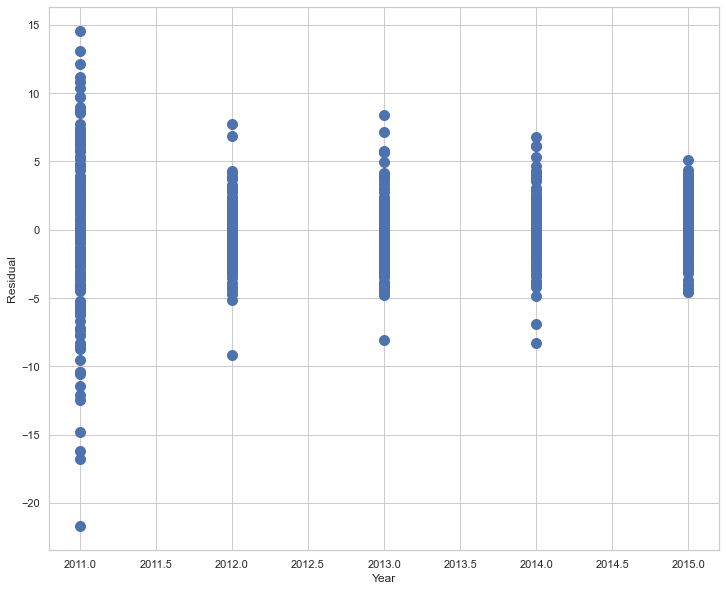

In [109]:
residual=test.life_expectancy-pred
def plt_residual(res):
  plt.scatter(test.year, res) 
  plt.ylabel('Residual')
  plt.xlabel("Year")

plt_residual(residual)

In [111]:
train=pd.read_csv('train.csv')

## Selected five random countries to assess accuracy of model. Note, Iraq has some missing values, but that is a constraint of this prediction problem as countries do not always publish life expectancy. 

In [114]:
random_countries = train['country'].sample(n=5)

In [122]:
chart = test[test.country.isin(random_countries)].copy()

x = train[train.country.isin(random_countries)].copy()

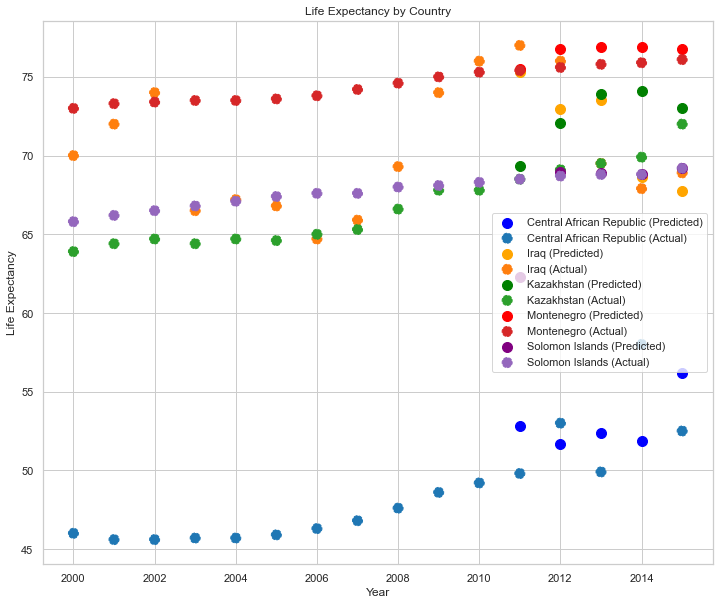

In [132]:
colors = ['blue', 'orange', 'green', 'red', 'purple']
color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Reshape the DataFrame using pivot_table
df_pivot = chart.pivot_table(values='pred', index='year', columns='country')
actual_pivot = x.pivot_table(values='life_expectancy', index='year', columns='country')

# Loop through the countries and create a line chart for each one with the same color
for i, country in enumerate(df_pivot.columns):
    plt.scatter(df_pivot.index, df_pivot[country], color=colors[i], label=country + ' (Predicted)')
    plt.scatter(actual_pivot.index, actual_pivot[country], linestyle='dashed', color=color[i], label=country + ' (Actual)')

# Add labels and legend to the chart
plt.xlabel('Year')
plt.ylabel('Life Expectancy')
plt.title('Life Expectancy by Country')
plt.legend()

# Display the chart
plt.show()



## Conclusions and Recommendations to stakeholder(s)

We intended for this problem to be a prediction problem, but we added inferential understanding to the model. Notably, as governments have the largest role to play in increasing life expectancy, it is important to understand the strongest predictors. From our analysis, due to the standardized ridge regression, these appear to be HIV, schooling, percentage expenditure, and income composition of resources. HIV outlines the prevalence of HIV in a country and has a severe negative affect on life expectancy. Governments should address through education and other reduction efforts. The other three predictors are based on government spending in one way or another. This is a limitation for developing countries, but it provides a model for the future as to how economic development should increase life expectancy. 